# Entrainement finetune de modèles pré-entraînés
Ce notebook présente :
- Pipeline de prétraitement à partir des splits de finetune
- Définition d’un modèle pré-entraîné
- Entraînement et évaluation
- Sauvegarde du meilleur modèle

## Imports & Setup

In [1]:
import os
import warnings
import pandas as pd
import dataframe_image as dfi
from datetime import date
import shutil
import subprocess
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics as km
from src.config_utils import load_config
from src.preprocessing_finetune import get_train_datagen, get_val_datagen
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from src.metrics import (
    compute_confusion_matrix, plot_confusion_matrix,
    compute_roc_pr, plot_roc_pr,
    compute_additional_metrics, calibration_plot,
    threshold_metrics_curve
)

In [2]:
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="keras\\.src\\.trainers\\.data_adapters\\.py_dataset_adapter"
)

CFG_OUT  = os.path.join('..','outputs','configs','all')
FIG_OUT  = os.path.join('..','outputs','figures', 'all', 'finetune')
LOG_OUT  = os.path.join('..','outputs','logs', 'all', 'finetune')

for d in (CFG_OUT, FIG_OUT, LOG_OUT):
    os.makedirs(d, exist_ok=True)

# Génération du Run ID: date + git hash
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

# Chargement de la configuration via un chemin relatif
config = load_config('../configs/config_finetune.yaml')
tf.random.set_seed(config['seed'])

print("Run ID :", run_id)

Run ID : 2025-07-06_4e06306


##  Lecture des splits et création des DataFrames

In [3]:
train_txt = "../splits/all/finetune/train.txt"
val_txt   = "../splits/all/finetune/val.txt"

with open(train_txt) as f: train_files = [l.strip() for l in f]
with open(val_txt)   as f: val_files   = [l.strip() for l in f]

train_df = pd.DataFrame({
    'filename': train_files,
    'class': [os.path.basename(os.path.dirname(p)) for p in train_files]
})

val_df = pd.DataFrame({
    'filename': val_files,
    'class': [os.path.basename(os.path.dirname(p)) for p in val_files]
})

## Générateurs Keras

In [4]:
train_datagen = get_train_datagen(config)
val_datagen   = get_val_datagen()

cw = config['loss']['class_weights']

train_df['weights'] = train_df['class'].map(cw)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    weight_col='weights',
    target_size=tuple(config['input']['size']),
    batch_size=config['input']['batch_size'],
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=tuple(config['input']['size']),
    batch_size=config['input']['batch_size'],
    class_mode='binary',
    shuffle=False
)

Found 413 validated image filenames belonging to 2 classes.
Found 89 validated image filenames belonging to 2 classes.


## Construction du modèle

In [5]:
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet' if config['model']['pretrained'] else None,
    input_shape=tuple(config['input']['size']) + (3,),
    pooling='avg'
)

x = layers.Dropout(0.4)(base.output)
output = layers.Dense(config['model']['num_classes'])(x)
model = models.Model(inputs=base.input, outputs=output)

## Compilation

In [6]:
opt = optimizers.AdamW(
    learning_rate=float(config['training']['optimizer']['lr']),
    weight_decay=float(config['training']['optimizer']['weight_decay'])
)

loss_fn = losses.BinaryCrossentropy(from_logits=True)

metric_list = [
    'accuracy',
    km.Precision(name='precision_toxic'),
    km.Recall(name='recall_toxic'),
    km.AUC(name='roc_auc'),
    km.AUC(name='pr_auc', curve='PR')
]

model.compile(optimizer=opt, loss=loss_fn, metrics=metric_list)

# model.summary()

## Callbacks et chemins

In [7]:
ckpt_dir = "../outputs/checkpoints/all/finetune"
os.makedirs(ckpt_dir, exist_ok=True)

ckpt_path = os.path.join(ckpt_dir, 'finetune_resnet50.keras')

es = callbacks.EarlyStopping(
    monitor=config['training']['callbacks']['early_stopping']['monitor'],
    mode=config['training']['callbacks']['early_stopping']['mode'],
    patience=config['training']['callbacks']['early_stopping']['patience']
)

mc = callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor=config['training']['callbacks']['model_checkpoint']['monitor'],
    mode=config['training']['callbacks']['model_checkpoint']['mode'],
    save_best_only=True
)

## Entraînement

In [8]:
history = model.fit(
    train_gen,
    epochs=config['training']['epochs'],
    validation_data=val_gen,
    callbacks=[es, mc],
)

Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.6205 - loss: 0.2966 - pr_auc: 0.7341 - precision_toxic: 0.7197 - recall_toxic: 0.4793 - roc_auc: 0.6966 - val_accuracy: 0.5955 - val_loss: 0.7089 - val_pr_auc: 0.5886 - val_precision_toxic: 0.5909 - val_recall_toxic: 1.0000 - val_roc_auc: 0.5346
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8299 - loss: 0.2532 - pr_auc: 0.8501 - precision_toxic: 0.8640 - recall_toxic: 0.8249 - roc_auc: 0.8515 - val_accuracy: 0.5843 - val_loss: 2.6011 - val_pr_auc: 0.5843 - val_precision_toxic: 0.5843 - val_recall_toxic: 1.0000 - val_roc_auc: 0.5000
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9065 - loss: 0.1210 - pr_auc: 0.9414 - precision_toxic: 0.9456 - recall_toxic: 0.8966 - roc_auc: 0.9319 - val_accuracy: 0.5843 - val_loss: 1.5806 - val_pr_auc: 0.5843 - val_precision_toxic: 0.5843 - val_recall_toxic: 1.0000 - val_roc_auc: 0.5000
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9133 -

## Sauvegarde de l’historique

In [9]:
hist_path = '../outputs/checkpoints/all/finetune/history_finetune_resnet50.pkl'
pd.to_pickle(history.history, hist_path)

# Sauvegarde de la config du run
src_cfg = '../configs/config_finetune.yaml'
dst_cfg = os.path.join(CFG_OUT, f"{run_id}_config_finetune.yaml")
shutil.copy(src_cfg, dst_cfg)
print("Config sauvegardée dans :", dst_cfg)

## Tracé des courbes d’entraînement

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 613ms/step


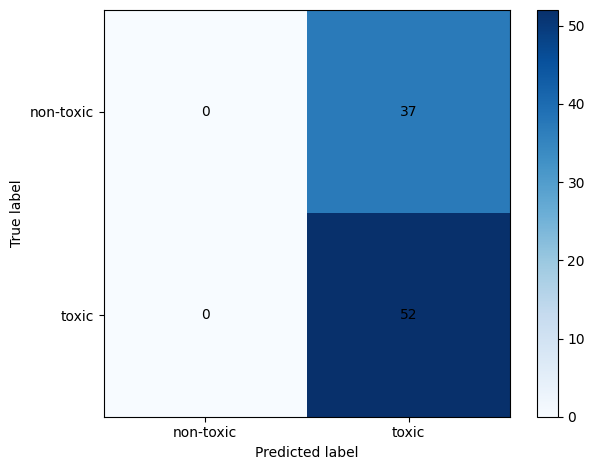

In [11]:
# 1) Prévisions sur le set de val
logits = model.predict(val_gen)
y_score = tf.sigmoid(logits).numpy().ravel()
y_true  = val_gen.classes
y_pred  = (y_score >= 0.5).astype(int)

# 2) Matrice de confusion
cm = compute_confusion_matrix(y_true, y_pred, normalize=False)

# Sauvegarde de la matrice
fig_path = os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png")
plt.savefig(fig_path, dpi=300)
print("Matrice sauvegardées dans :", fig_path)

plt.show(plot_confusion_matrix(cm))

In [12]:
# 3) Classification report
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Sauvegarde du rapport
fig_path = os.path.join(FIG_OUT, f"{run_id}_classification_report.png")
dfi.export(report, fig_path)
print("Rapport sauvegardées dans :", fig_path)

display(pd.DataFrame(report).T)

,precision,recall,f1-score,support
0,0.000000,0.00000,0.000000,37.00000
1,0.584270,1.00000,0.737589,52.00000
accuracy,0.584270,0.58427,0.584270,0.58427
macro avg,0.292135,0.50000,0.368794,89.00000
weighted avg,0.341371,0.58427,0.430951,89.00000


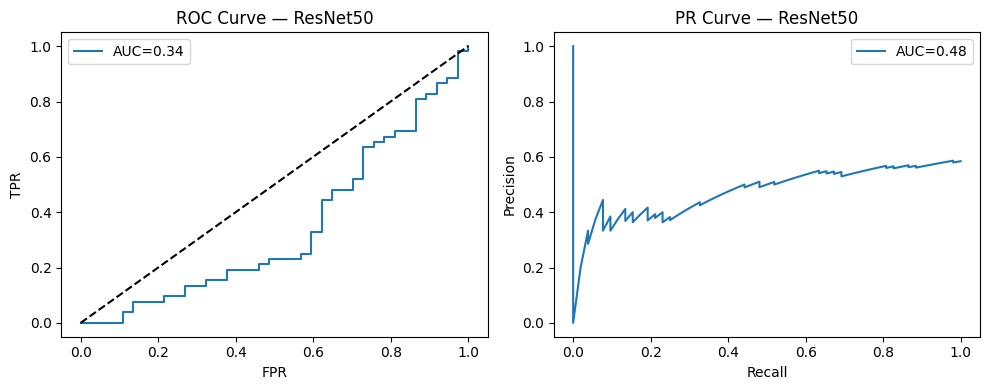

In [13]:
# 4) ROC & PR
roc_pr, pr = compute_roc_pr(y_true, y_score)

# Sauvegarde des ROC & PR
fig_path = os.path.join(FIG_OUT, f"{run_id}_ROC_PR.png")
plt.savefig(fig_path, dpi=300)
print("ROC & PR sauvegardées dans :", fig_path)

plt.show(plot_roc_pr(roc_pr, pr, name='ResNet50'))

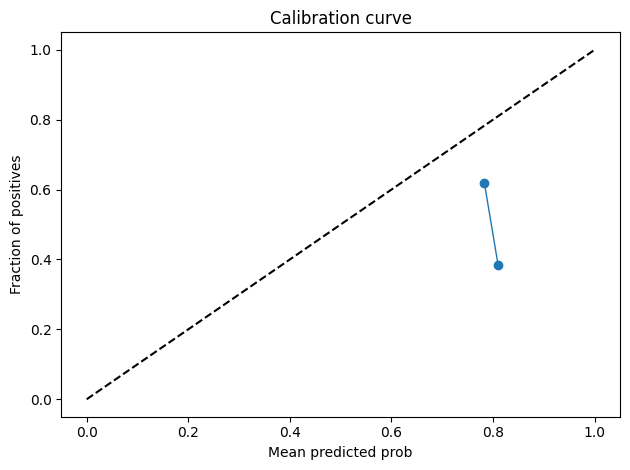

In [14]:
# 5) Calibration

# Sauvegarde de la courbe de calibration
fig_path = os.path.join(FIG_OUT, f"{run_id}_calibration.png")
plt.savefig(fig_path, dpi=300)
print("Courbe de calibration sauvegardées dans :", fig_path)

plt.show(calibration_plot(y_true, y_score, n_bins=10))

In [15]:
# 6) MCC, balanced acc
met = compute_additional_metrics(y_true, y_pred, y_score)
print(f"MCC: {met['mcc']:.3f}  —  Balanced acc: {met['balanced_acc']:.3f}")

MCC: 0.000  —  Balanced acc: 0.500


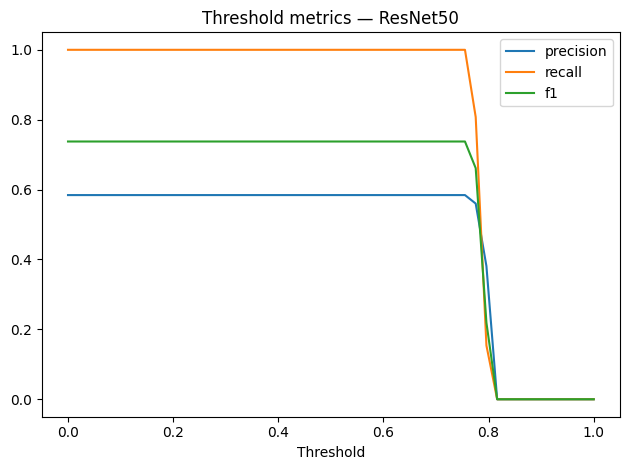

In [16]:
# 7) Courbes selon seuil

# Sauvegarde des Threshold
fig_path = os.path.join(FIG_OUT, f"{run_id}_threshold_mertics.png")
plt.savefig(fig_path, dpi=300)
print("Threshold metrics sauvegardées dans :", fig_path)

plt.show(threshold_metrics_curve(y_true, y_score, name='ResNet50'))